### Introduction
The objective of this project was to build a machine learning model to detect fraudulent credit card transactions from given data. The Kaggle dataset used in this notebook can be found [here](https://www.kaggle.com/mlg-ulb/creditcardfraud). We approach the problem from two perspectives, first trying to use tradiotionam ML models which minimize misclassification ignoring the costs and second by trying to minimize the cost while allowing higher missclassfication.
Following three methods have been illustrated to explore this:
1. Traditional ML models which try to which minimize misclassification
2. Cost sensitive classification using Bayes minimum risk classifier
3. Threshold optimization to minimize costs

In [69]:
#importing libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_validate, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve

In [2]:
data = pd.read_csv('creditcard.csv')

In [3]:
data.shape

(284807, 31)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
data.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [6]:
np.round(data.describe(),2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


In [7]:
# Fraud transactions - Check target class imbalance
data['Class'].value_counts(normalize = True) * 100

0    99.827251
1     0.172749
Name: Class, dtype: float64

<AxesSubplot:xlabel='Class', ylabel='Amount'>

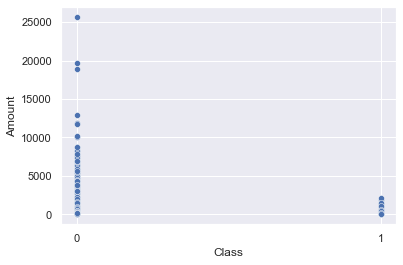

In [8]:
sns.set()
sns.scatterplot(x = data['Class'].astype(str), y = data['Amount'])

### 1 . Do nothing strategy
We will use this as basline to understand the financial impact of fraudulent transactions. As the fraud rate is only 0.17% we ignore them and absorb all the losses arising from these transactions. In this case the losses will amount to actual fraudulent transaction amount. The calculations below show that we end up losing $60k by not acting on fraud transactions.

In [60]:
print('Valid transactions by value: ', data[data['Class'] == 0].Amount.sum())
print('Revenue on valid transactions: ', np.round(0.0175 * data[data['Class'] == 0].Amount.sum()))
print('Fraudulent transactions by value: ', np.round(data[data['Class'] == 1].Amount.sum()))

Valid transactions by value:  25102462.04
Revenue on valid transactions:  439293.0
Fraudulent transactions by value:  60128.0


We want to design approaches which will help us to identify these frauds and minimize the financial impact of such transactions. In the sections below we will use ML models to identify fraudulent transactions and then evaluate different model versions basis the resultant cost savings.

### 2. ML model without handling imbalance
In this section we will build models using **Logistic regression** and **Random forest** algorithms for identifying the fraudulent transactions and evaluate performance of both models using both traditional evaluation metrics and financial metrics. It is possible that the model which gives the best statistical measure may not be the best in terms of financial metrics. In this particular case of fraud detection we will select a model which gives highest financial benefit.<br>

**a.** Given the class imbalance we will use **F1 score** as statistical evaluation measure. <br> 
**b.** Assumptions for computing financial metric (Cost of predicition):<br>
1. Interchange fee = 1.75% of txn value (Revenue earned by bank & paid by merchant on each trasaction)
2. Administrative cost of blocking a transaction = $3
**c.** Financial metric -  **cost saving** by using ML model over no action strategy: <br>
1. Cost of False negative (CFN) = Entire transaction value (Assuming bank has to give full refund to the customer)
2. Cost of True positive (CTP)  = \\$3 (Administrative cost)
3. Cost of False positive (CFP) = \\$3 + 0.3 * 1.75 * txn value (Administrative cost + assuming that only 70% of transactions will happen again post blocking)
4. Cost of True negative = 0

**Total cost = CFN + CTP + CFP** <br>
**% Cost saving = 1 - (Total cost) / (Cost of no action)**

In [10]:
#Stratified sampling to split into train and test data
X_train, X_test, Y_train, Y_test = train_test_split(data.iloc[:,:-1], data['Class'], train_size = 0.8, stratify = data['Class'], random_state = 10)
X_train.drop('Time', axis = 'columns', inplace = True)
X_test.drop('Time', axis = 'columns', inplace = True)

In [11]:
#Check bad rate in train and test post split
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

print("Bad rate in train: {:.3%}".format(Y_train.sum()/len(Y_train)))
print("Bad rate in test: {:.3%}".format(Y_test.sum()/len(Y_test)))

(227845, 29)
(56962, 29)
(227845,)
(56962,)
Bad rate in train: 0.173%
Bad rate in test: 0.172%


In [12]:
def model_fit(model, X_train, Y_train, X_test, Y_test):
    
    result = {}
    
    cv_result = cross_validate(model, X_train, Y_train, scoring = 'f1')
    result['cv_fit_time'] = np.mean(cv_result['fit_time'])
    result['cv_f1_score'] = np.mean(cv_result['test_score'])
    
    model.fit(X_train, Y_train)
    
    result['f1_test']    = f1_score(Y_test, model.predict(X_test))
    result['cost_save_train'] = cost_save(Y_train, model.predict(X_train), X_train['Amount'])
    result['cost_save_test']  = cost_save(Y_test, model.predict(X_test), X_test['Amount'])

    return result

In [13]:
def cost_save(true_labels, pred_labels, amount):
    
    TP_cost = np.sum(((true_labels == 1) & (pred_labels == 1)) * 3)
    FP_cost = np.sum(((true_labels == 0) & (pred_labels == 1)) * (0.3*1.75/100*amount + 3))
    FN_cost = np.sum(((true_labels == 1) & (pred_labels == 0)) * amount) 
    total_cost = TP_cost + FP_cost + FN_cost
    
    cost_all_neg = (true_labels * amount).sum()
    cost_save = np.round(1 - (total_cost/cost_all_neg),2)
    
    return cost_save

In [14]:
ct = make_column_transformer((StandardScaler(), ['Amount']), remainder = 'passthrough')
logreg = LogisticRegression(random_state=101)
pipe_lr = make_pipeline(ct, logreg)

rf = RandomForestClassifier(random_state=101)

final_result = {}
for model in [pipe_lr,rf]:
    clf_name = model.__class__.__name__
    final_result[clf_name] = model_fit(model, X_train, Y_train, X_test, Y_test)
    print('-'*12 + clf_name + '-'*12)
    print('cross validation f1 score: {:0.2f}'.format(final_result[clf_name]['cv_f1_score']))
    print('f1 score test data: {:0.2f}'.format(final_result[clf_name]['f1_test']))
    print('cost save test data: {:0.2%}\n'.format(final_result[clf_name]['cost_save_test']))

------------Pipeline------------
cross validation f1 score: 0.73
f1 score test data: 0.68
cost save test data: 37.00%

------------RandomForestClassifier------------
cross validation f1 score: 0.85
f1 score test data: 0.84
cost save test data: 76.00%



As seen above Random forest performs better in terms of both F1-score and cost savings as compared to Logistic regression.

In [15]:
import gc
gc.collect()

340

### 3. Cost sensitive approach - Bayes mimimum risk classifier
The models in the previous section try and minimize misclassification of target labels.However in certain problems it is necessary to allow higher misclassification, in order to minimize the financial impact or overall cost. Also traditional models assume that all the misclassifications carry same costs whereas in reality the costs may differ by type of misclassifiaction as well as across samples (different transaction amounts in this case). This forms the basis of **cost sensitive learning**. <br>
**Bayes minimum risk classifier** is one of the ways of applying cost sensitive learning. Here we make the predictions with lowest expected cost i.e. **we classifiy the transaction as fraud if the expected cost of classifying transaction as fraud is less than the expected cost of classifying it as legitimate**. The expected costs are calculated using the same cost framework used in the above section and using the probabilites that are given by the above models.

In [17]:
def cost_sensitive_BMR(model, X):
    p1 = model.predict_proba(X)[:,1]
    p0 = model.predict_proba(X)[:,0]
    cost_1 = 3 * p1 + (3 + 0.3 * 1.75/100 * X['Amount']) * p0
    cost_0 = X['Amount'] * p1
    return (cost_1 < cost_0)

In [67]:
for model in [pipe_lr, rf]:
    result = {}
    clf_name = model.__class__.__name__ + '_BMR'
    
    y_pred_train_BMR = cost_sensitive_BMR(model, X_train)
    y_pred_test_BMR = cost_sensitive_BMR(model, X_test)
    
    result['f1_train'] = f1_score(Y_train, y_pred_train_BMR)
    result['f1_test'] = f1_score(Y_test, y_pred_test_BMR)
    result['cost_save_train'] = cost_save(Y_train, y_pred_train_BMR, X_train['Amount'])
    result['cost_save_test'] = cost_save(Y_test, y_pred_test_BMR, X_test['Amount'])
    final_result[clf_name] = result

    print('-'*12 + clf_name +'-'*12)
    print('f1 score train data: {:0.2f}'.format(final_result[clf_name]['f1_train']))
    print('f1 score test data: {:0.2f}'.format(final_result[clf_name]['f1_test']))
    print('cost save train data: {:0.2%}'.format(final_result[clf_name]['cost_save_train']))
    print('cost save test data: {:0.2%}\n'.format(final_result[clf_name]['cost_save_test']))

------------Pipeline_BMR------------
f1 score train data: 0.51
f1 score test data: 0.49
cost save train data: 69.00%
cost save test data: 77.00%

------------RandomForestClassifier_BMR------------
f1 score train data: 0.44
f1 score test data: 0.22
cost save train data: 88.00%
cost save test data: 71.00%



As seen above the cost save for the logistic regression improves from 37% to 77%, at the expense of a lower f1 score (as we chose to minimize cost while allowing misclassification). However the cost savings of random forest algorithm drop marginally from 76% to 71% using cost sensitive approach.

In [19]:
final_result

{'Pipeline': {'cv_fit_time': 1.8425366401672363,
  'cv_f1_score': 0.7264187353386061,
  'f1_test': 0.6832298136645963,
  'cost_save_train': 0.49,
  'cost_save_test': 0.37},
 'RandomForestClassifier': {'cv_fit_time': 155.82818851470947,
  'cv_f1_score': 0.8545211810929448,
  'f1_test': 0.8426966292134831,
  'cost_save_train': 0.97,
  'cost_save_test': 0.76},
 'Pipeline_BMR': {'f1_train': 0.5081240768094534,
  'f1_test': 0.485207100591716,
  'cost_save_train': 0.69,
  'cost_save_test': 0.77},
 'RandomForestClassifier_BMR': {'f1_train': 0.4368266405484819,
  'f1_test': 0.21634615384615383,
  'cost_save_train': 0.88,
  'cost_save_test': 0.71}}

### 4. Threshold optimization approach

Another way of dealing with class imbalance in data is to tune the probability threshold that is used to make predictions (default threshold is 0.5). In the section below we define a set of threholds and evaluate the model performance across each of these. We select the threshold which gives us the highest cost savings for making future prerdictions.

In [20]:
def optimum_threshold(model, X_test, Y_test):
    
    cs = []
    f1 = []

    thresholds = np.linspace(0,1,50)
    for threshold in thresholds:
        pred_labels = model.predict_proba(X_test)[:,1] >= threshold
        cs.append(cost_save(Y_test, pred_labels, X_test['Amount']))
        f1.append(f1_score(Y_test, pred_labels))

    ix = np.argmax(cs)
        
    return cs[ix], f1[ix], thresholds[ix]

In [46]:
for model in [pipe_lr, rf]:
    result = {}
    clf_name = model.__class__.__name__ + '_ThreshOpt'
    result['cost_save_test'], result['f1_test'], result['threshold'] = optimum_threshold(model, X_test, Y_test)
    final_result[clf_name] = result
    
    print('-'*12 + clf_name +'-'*12)
    print('Best cost save {:.0%} at threshold {:0.4f} and f1_score of {:0.2f}\n'.format(result['cost_save_test'], t, result['f1_test'])) 
    

------------Pipeline_ThreshOpt------------
Best cost save 79% at threshold 0.0408 and f1_score of 0.78

------------RandomForestClassifier_ThreshOpt------------
Best cost save 81% at threshold 0.0408 and f1_score of 0.65



As seen above we improve the cost savings for both the classifiers by tuning the probability threhold for making predictions.

In [47]:
final_result

{'Pipeline': {'cv_fit_time': 1.8425366401672363,
  'cv_f1_score': 0.7264187353386061,
  'f1_test': 0.6832298136645963,
  'cost_save_train': 0.49,
  'cost_save_test': 0.37},
 'RandomForestClassifier': {'cv_fit_time': 155.82818851470947,
  'cv_f1_score': 0.8545211810929448,
  'f1_test': 0.8426966292134831,
  'cost_save_train': 0.97,
  'cost_save_test': 0.76},
 'Pipeline_BMR': {'f1_train': 0.5081240768094534,
  'f1_test': 0.485207100591716,
  'cost_save_train': 0.69,
  'cost_save_test': 0.77},
 'RandomForestClassifier_BMR': {'f1_train': 0.4368266405484819,
  'f1_test': 0.21634615384615383,
  'cost_save_train': 0.88,
  'cost_save_test': 0.71},
 'Pipeline_ThreshOpt': {'cost_save_test': 0.79,
  'f1_test': 0.7766990291262137,
  'threshold': 0.04081632653061224},
 'RandomForestClassifier_ThreshOpt': {'cost_save_test': 0.81,
  'f1_test': 0.6509803921568628,
  'threshold': 0.04081632653061224}}

### Summary
The table below summarizes the f1 score and cost savings for each of the model vesrions that were described in the above sections. Threshold optimization gives the best performance in terms of cost savings for both Logistic regression and Random forests. **The best preformance overall is given by Random forest classfier with threshold optimization where we achieve a cost saving of 81% (with F1 score of 0.65).**

In [45]:
result_df = pd.DataFrame(final_result).loc[['f1_test','cost_save_test']]
result_df.columns = [col.replace('Pipeline', 'LogisticReg') for col in result_df.columns]
result_df.T

,f1_test,cost_save_test
LogisticReg,0.683230,0.37
RandomForestClassifier,0.842697,0.76
LogisticReg_BMR,0.485207,0.77
RandomForestClassifier_BMR,0.216346,0.71
LogisticReg_ThreshOpt,0.776699,0.79
RandomForestClassifier_ThreshOpt,0.650980,0.81


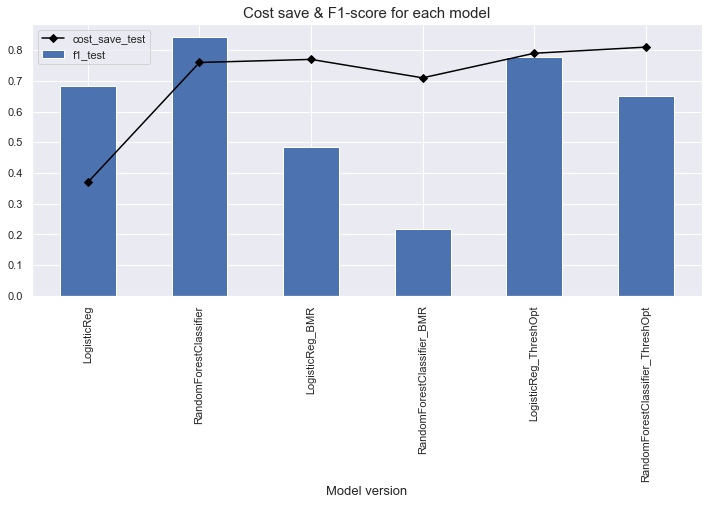

In [57]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
df = result_df.T
df.reset_index().plot(x = 'index', y = 'cost_save_test', ax=ax, style = '-', marker = 'D', color = 'black')
df.reset_index().plot(kind = 'bar', x = 'index', y = 'f1_test', ax=ax)
plt.title('Cost save & F1-score for each model', {'fontsize':15})
plt.xlabel('Model version',{'fontsize':13})
plt.show()

In [59]:
import joblib
joblib.dump(pipe_lr, 'logreg.pkl')
joblib.dump(rf, 'rf.pkl')
joblib.dump(final_result, 'final_result.pkl')

['final_result.pkl']